              precision    recall  f1-score   support

         0.0       0.72      0.79      0.75       123
         1.0       0.63      0.54      0.58        83

    accuracy                           0.69       206
   macro avg       0.68      0.67      0.67       206
weighted avg       0.68      0.69      0.68       206

Confusion Matrix:
[[97 26]
 [38 45]]


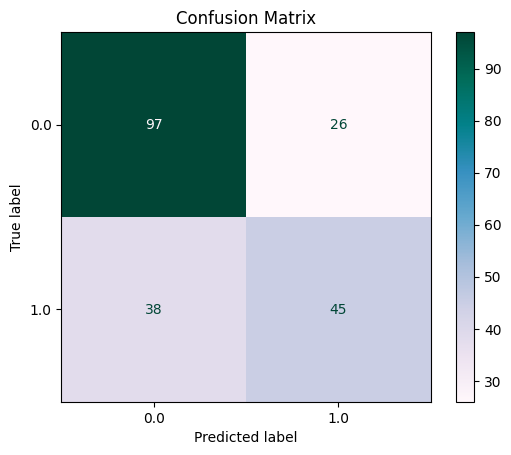

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split #Daten in Trainings- und Testdaten werden  aufgeteilt. Das ist wichtig, um später objektiv zu überprüfen, wie gut das Modell generalisiert.
from sklearn.pipeline import Pipeline #Pipeline erlaubt, mehrere Schritte (z. B. Vorverarbeitung + Modelltraining) sauber zusammenzufassen.
from sklearn.preprocessing import OneHotEncoder, StandardScaler #StandardScaler: Skaliert numerische Werte (Mittelwert 0, Standardabweichung 1),OneHotEncoder: Wandelt Kategorien  in numerische Spalten (Dummy-Variablen) um.
from sklearn.compose import ColumnTransformer #erlaubt unterschiedliche Vorverarbeitung für numerische und kategoriale Spalten anzuwenden.
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin

# Custom Transformer zur Umwandlung von Author_Rating in Zahlen
class AuthorRatingMapper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.rating_map = {
            "Novice": 1,
            "Intermediate": 2,
            "Famous": 3,
            "Excellent": 4
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if 'Author_Rating' in X.columns:
            X['Author_Rating'] = X['Author_Rating'].map(self.rating_map)
        return X
##########################################################
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report # eine Auswertung des Modells: Genauigkeit, Präzision, Recall, F1-Score – für beide Klassen (verfilmt / nicht verfilmt).
##########################################################
# Bereinigte Datei laden
df = pd.read_csv("book_data_clean.csv", sep=";", encoding="utf-8")

#  Filter: Nur Bücher ab 1950 behalten
#df = df[df['Publishing_Year'] >= 1950]


# Ziel & Features
y = df['Adapted_to_Film']# Zielvariable/Label. Das Modell soll lernen, ob ein Buch verfilmt wurde (1) oder nicht (0).
X = df.drop(columns=['Adapted_to_Film', 'Book_Name'])# es wird ZIELspalte entfernt und BOOK_Name , das stört im Model

#Publisher & Autoren gruppieren
top_publishers = X['Publisher'].value_counts().nlargest(10).index #Top 10 Publisher behalten.
X['Publisher'] = X['Publisher'].where(X['Publisher'].isin(top_publishers), other='other')#Alle anderen als "other" gruppiert
top_authors = X['Author'].value_counts().nlargest(10).index
X['Author'] = X['Author'].where(X['Author'].isin(top_authors), other='Sonstige')
# Numerische und kategoriale Features trennen

numerical_features = ['Publishing_Year', 'Author_Rating', 'Average_Rating', 'Rating_Count', 'Gross_Sales_EUR']

#numerical_features = [ 'Publishing_Year', 'Author_Rating','Average_Rating',  'Gross_Sales_EUR']

categorical_features = ['Language_Code', 'Genre', 'Publisher', 'Author']
#categorical_features = [ 'Genre']


#verarbeitung mit ColumnTransformer
#numerical_features: mit StandardScaler skalieren
#categorical_features: mit OneHotEncoder in Dummy-Variablen umwandeln

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])


# Pipeline mit Mapper + Preprocessing + Modell
pipeline = Pipeline(steps=[
    ('author_rating_mapper', AuthorRatingMapper()),
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42,  class_weight={0:1, 1:2}))])

#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



#Modell trainieren
pipeline.fit(X_train, y_train)#Der Preprocessing-Schritt auf X_train angewendet,  RandomForest-Modell mit den verarbeiteten Daten trainiert

#Vorhersage & Auswertung: mach Vorhersage mit x_test und 
y_pred = pipeline.predict(X_test)#vergleiche Vorhersagey_pred mit echten Werten- y_test
print(classification_report(y_test, y_pred))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Vorhersagen (du hast y_pred schon)
# y_pred = pipeline.predict(X_test)

# Confusion Matrix berechnen
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix ausgeben
print("Confusion Matrix:")
print(cm)

# Confusion Matrix visualisieren
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap=plt.cm.PuBuGn)
plt.title("Confusion Matrix")
plt.show()
